# Assignment 1: Analysing and Tracking the Sentiment and Topics on Social Media 🧠💬

## Project Overview: Sentiment Analysis and Topic Modeling on Reddit Cryptocurrency Posts 📈

### By: Avrio Lopes                                                                                                                       ID: s4102909

In this project, we analyze textual data collected from the **r/CryptoCurrency** subreddit to explore public sentiment and uncover dominant discussion topics. The workflow includes:

- **Data Collection**: Using the `praw` API, we extract up to 100 Reddit posts and their top 50 comments each.
- **Pre-processing**: Text is cleaned and normalized by removing noise (URLs, punctuation, stopwords, etc.) and standardizing content for analysis.
- **Sentiment Analysis**:
  - A **Lexicon-based approach** computes sentiment scores using predefined positive and negative word lists.
  - A **VADER-based method** leverages a pretrained model from NLTK to evaluate the emotional tone of text.
  - Sentiment scores are categorized and visualized using pie charts, histograms, and comparison plots to assess agreement or divergence between the two approaches.
- **Topic Modeling**: Using **Latent Dirichlet Allocation (LDA)**, we identify the underlying themes in the discussion and visualize them with WordClouds and pyLDAvis.

### Objective:
To gain insights into **public opinion trends**, **dominant conversation topics**, and to **compare sentiment scoring methods** applied to real-world social media data in the context of cryptocurrency.

## Importing Required Libraries 🧩

The below code block imports all the necessary libraries used throughout the notebook for data collection, text processing, sentiment analysis, topic modeling, and visualization.

In [1]:
import re
import praw
import time
import string
import pyLDAvis
import numpy as np
import pandas as pd
import seaborn as sns
import pyLDAvis.lda_model
from tabulate import tabulate
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
from nltk.corpus import stopwords
from nltk.tokenize.treebank import TreebankWordTokenizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

## Reddit Data Collector 🚀

The below code block uses the `praw` library to collect the latest posts and top comments from the **r/CryptoCurrency** subreddit. It gathers up to 1000 posts and 50 comments per post, then saves the combined data to a dataframe for analysis.

In [2]:
reddit = praw.Reddit(
    client_id="OJtDOFbkvxW9oodT0qSozw",
    client_secret="6unjzbEWPaQoomY7uRYq0mQIia80IQ",
    user_agent="moon_rover69"
)

subreddit_name = "CryptoCurrency"
subreddit = reddit.subreddit(subreddit_name)

combined_data = []

print("Fetching upto 1000 posts and top 50 comments each...")

for idx, submission in enumerate(subreddit.new(limit=1000)):
    # Add the post itself
    print(f"Fetching comments for post: {idx}: {submission.title}")
    combined_data.append({
        'id': submission.id,
        'type': 'submission',
        'title': submission.title,
        'selftext': submission.selftext,
        'created_utc': submission.created_utc
    })

# Fetch comments
    submission.comments.replace_more()
    for comment in submission.comments.list()[:50]:
        combined_data.append({
            'id': comment.id,
            'type': 'comment',
            'title': None,
            'selftext': comment.body,
            'created_utc': comment.created_utc
        })

    if (idx + 1) % 100 == 0:
        print(f"{idx + 1} posts processed...")
        time.sleep(1)

df = pd.DataFrame(combined_data)
df.to_csv("reddit_combined_posts_and_comments.csv", index=False)

print("✅ Done! Data saved with matching format.")

Fetching upto 1000 posts and top 50 comments each...
Fetching comments for post: 0: Coinbase’s Base Network Allegedly Fueled a $16 Million Pump and Dump
Fetching comments for post: 1: Daily Crypto Discussion - April 17, 2025 (GMT+0)
Fetching comments for post: 2: How I Got My Ass Finally Fixed (and learned a thing or two about bitcoin too!) [PostOp]
Fetching comments for post: 3: Fed Chair Powell Says Crypto And Banking Rules Will 'Loosen' As Sector Matures
Fetching comments for post: 4: Brian Eno perfectly explains selfishness of the super rich
Fetching comments for post: 5: Sam Bankman-Fried's latest California prison once housed Al Capone
Fetching comments for post: 6: Me After Sending My First Crypto Transaction, And Also After Sending My 1,000th
Fetching comments for post: 7: BAYC Holder Accidentally Sends Away Both a Rare NFT and 25 ETH Due to OpenSea “Make a Deal” Misstep
Fetching comments for post: 8: New scam found - be aware
Fetching comments for post: 9: News Flash: Powell s

## Setup and Pre-processing for Reddit Posts 🛠️

The below code block performs text cleaning and normalization on Reddit post content. Then, it merges post titles and descriptions, removes noise such as URLs, punctuation, mentions, and zero-width spaces, replaces common abbreviations, tokenizes using `TreebankWordTokenizer`, and filters out stopwords. It also removes any posts that contain the phrase **"I am a bot"** (typically from automated responses). The resulting clean text is prepared for downstream sentiment analysis and topic modeling.

In [3]:
# Load English stopwords
stop_words = set(stopwords.words('english'))

tokenizer = TreebankWordTokenizer()

# Common abbreviation replacements
abbreviations = {
    "lol": "laugh out loud",
    "omg": "oh my god",
    "idk": "i don't know",
    "rn": "right now",
    "u": "you",
    "ur": "your",
    "btw": "by the way",
    "brb": "be right back",
    "thx": "thanks",
    "pls": "please"
}

def preprocess_text(text):
    if not text or not isinstance(text, str):
        return ""
    # Remove zero-width spaces
    text = text.replace('\u200b', '')
    # Convert to lowercase
    text = text.lower()
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    # Remove mentions (e.g., @username)
    text = re.sub(r'@\w+', '', text)
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Tokenize using TreebankWordTokenizer
    tokens = tokenizer.tokenize(text)
    # Replace abbreviations
    tokens = [abbreviations.get(word, word) for word in tokens]
    # Remove stopwords
    filtered_tokens = [word for word in tokens if word not in stop_words]
    # Return the clean, preprocessed text
    return ' '.join(filtered_tokens)

# Combine title and selftext to handle missing values
df['raw_text'] = df['title'].fillna('') + " " + df['selftext'].fillna('')

# Remove rows with "I am a bot"
df = df[~df['raw_text'].str.contains("i am a bot", case=False, na=False)]

# Apply the preprocessing
df['clean_text'] = df['raw_text'].apply(preprocess_text)

print("Sample pre-processed text:")
def truncate(text, length=60):
    return text if len(text) <= length else text[:length] + "..."

rows = [
    [truncate(orig), truncate(clean)]
    for orig, clean in zip(df['raw_text'], df['clean_text'])
][:10] 

headers = ["Original Text", "Cleaned Text"]

print(tabulate(rows, headers=headers, tablefmt="grid"))

Sample pre-processed text:
+-----------------------------------------------------------------+-----------------------------------------------------------------+
| Original Text                                                   | Cleaned Text                                                    |
+=================================================================+=================================================================+
| Coinbase’s Base Network Allegedly Fueled a $16 Million Pump ... | coinbase’s base network allegedly fueled 16 million pump dum... |
+-----------------------------------------------------------------+-----------------------------------------------------------------+
| Those are rookie numbers, you gotta pump those up!              | rookie numbers got ta pump                                      |
+-----------------------------------------------------------------+-----------------------------------------------------------------+
| Doesn't this happen on a daily ba

## Word Frequency and N-Gram Analysis 📊🧾

The following code blocks analyze the cleaned Reddit text by identifying frequently used terms in the discussions:

- **Top 20 Most Common Words**: This section uses a simple `Counter` to extract and visualize the most frequently occurring individual words (unigrams) in a horizontal bar chart, helping highlight commonly discussed terms.

- **Unigram and Bigram Analysis**: Using `CountVectorizer`, we extract and plot the top 20 **unigrams** (single words) and **bigrams** (two-word combinations). These plots help uncover both individual word importance and frequently co-occurring word pairs that may represent key phrases or concepts in the cryptocurrency space.

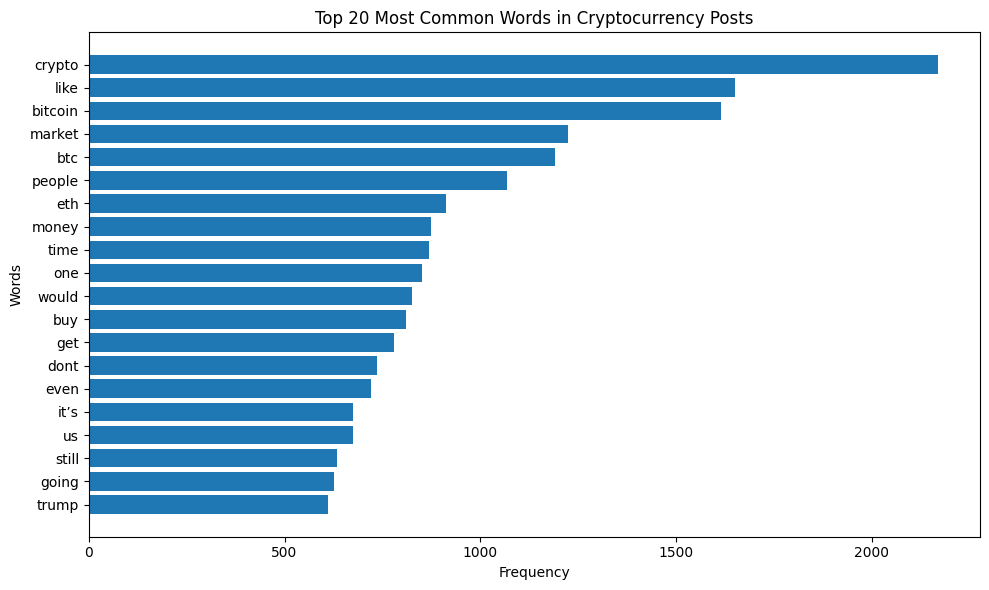

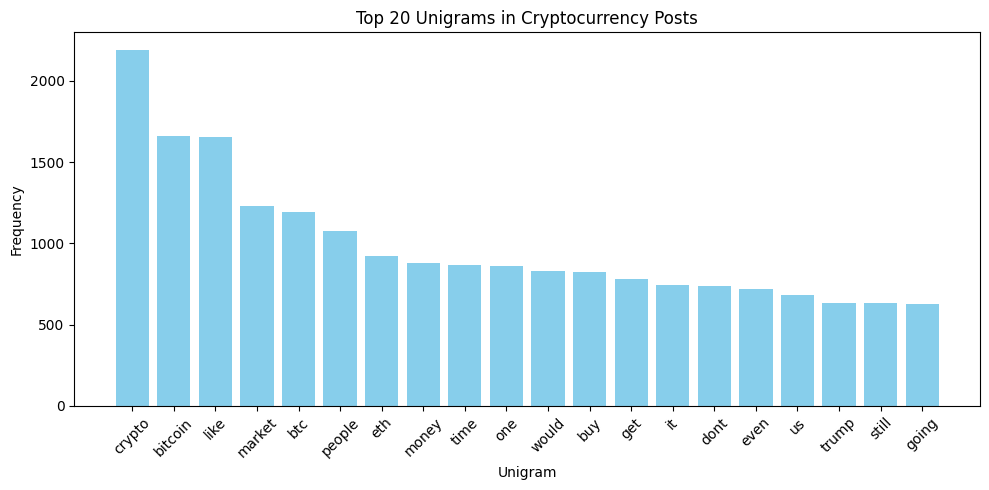

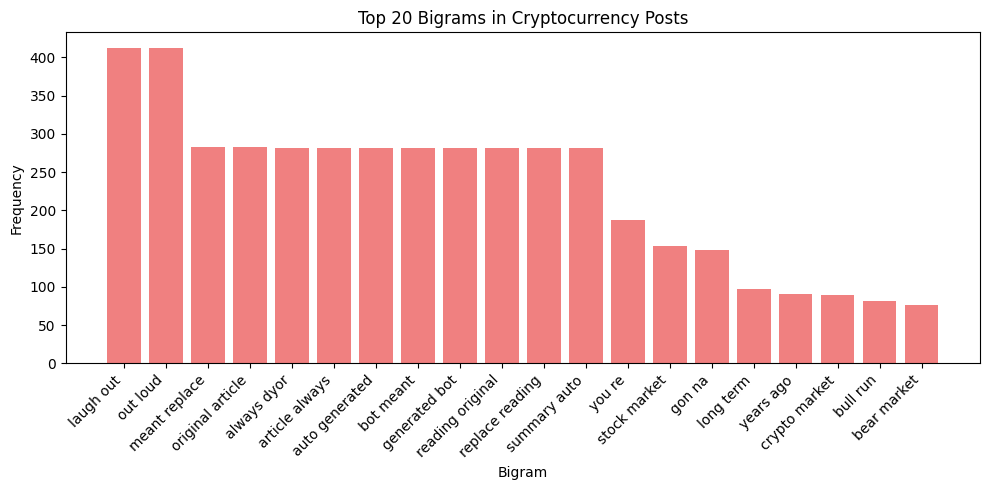

In [4]:
# Get Word Frequency using Counter
all_text = " ".join(df['clean_text'].tolist())
tokens = all_text.split()
word_counts = Counter(tokens)
word_counts_df = pd.DataFrame(word_counts.most_common(20), columns=['word', 'frequency'])

# Plot Top 20 Words (Counter-based)
plt.figure(figsize=(10, 6))
plt.barh(word_counts_df['word'][::-1], word_counts_df['frequency'][::-1])
plt.xlabel('Frequency')
plt.ylabel('Words')
plt.title('Top 20 Most Common Words in Cryptocurrency Posts')
plt.tight_layout()
plt.show()

# Unigram Frequency using CountVectorizer
vectorizer_uni = CountVectorizer()
X_uni = vectorizer_uni.fit_transform(df['clean_text'])
unigram_counts = zip(vectorizer_uni.get_feature_names_out(), X_uni.toarray().sum(axis=0))
top_unigrams = sorted(unigram_counts, key=lambda x: x[1], reverse=True)[:20]

# Plot Top 20 Unigrams
plt.figure(figsize=(10, 5))
plt.bar([u[0] for u in top_unigrams], [u[1] for u in top_unigrams], color='skyblue')
plt.title("Top 20 Unigrams in Cryptocurrency Posts")
plt.xlabel("Unigram")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Bigram Frequency using CountVectorizer
vectorizer_bi = CountVectorizer(ngram_range=(2, 2))
X_bi = vectorizer_bi.fit_transform(df['clean_text'])
bigram_counts = zip(vectorizer_bi.get_feature_names_out(), X_bi.toarray().sum(axis=0))
top_bigrams = sorted(bigram_counts, key=lambda x: x[1], reverse=True)[:20]

# Plot Top 20 Bigrams
plt.figure(figsize=(10, 5))
plt.bar([b[0] for b in top_bigrams], [b[1] for b in top_bigrams], color='lightcoral')
plt.title("Top 20 Bigrams in Cryptocurrency Posts")
plt.xlabel("Bigram")
plt.ylabel("Frequency")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Lexicon-Based Sentiment Categorization and Visualization 📊

The below code block applies a rule-based approach to sentiment analysis using predefined positive and negative word lists. Each cleaned Reddit post is scored by counting the number of positive and negative words it contains, providing a simple sentiment measure based on the difference between the two counts. The analysis is then done by assigning each Reddit post a sentiment label: **positive**, **negative**, or **neutral**, based on the computed sentiment score. It then visualizes the results using:

- A **lexicon-based histogram with kernel density estimation (KDE)** to show the distribution of sentiment scores.
- A **bar chart** to display the number of posts in each lexicon-based sentiment category.


Sample Sentiment Scores (Lexicon-Based):
                                          clean_text  lex_sentiment
0  coinbase’s base network allegedly fueled 16 mi...             -1
1                         rookie numbers got ta pump              0
2                   doesnt happen daily basis solana              0
3  tldr coinbases layer 2 network base scrutiny o...             -9
4  people file class action lawsuit coins got sni...             -1


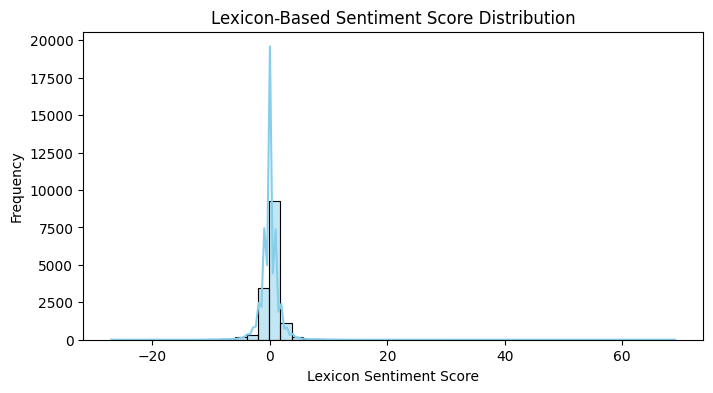

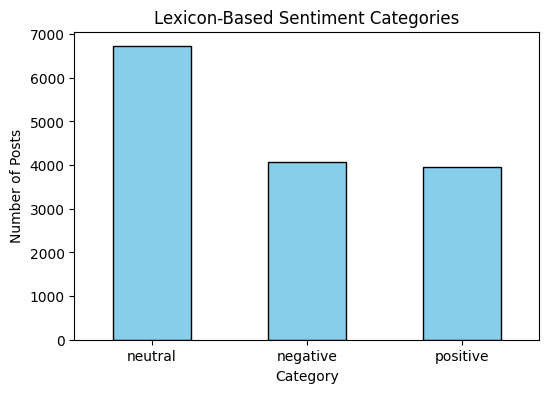

In [5]:
def load_word_list(filename):
    # Attempt to read the file using different possible encodings
    encodings = ['utf-8', 'latin-1', 'cp1252']
    for enc in encodings:
        try:
            with open(filename, 'r', encoding=enc) as f:
                lines = f.readlines()
            break
        except UnicodeDecodeError:
            continue
    else:
        raise UnicodeDecodeError(f"Could not decode {filename} using available encodings.")
    
    words = set()
    # Process each line, skipping comments and empty lines
    for line in lines:
        if line.startswith(';') or line.strip() == '':
            continue
        words.add(line.strip())
    return words

# Load the word lists as given in class
positive_words = load_word_list('positive-words.txt')
negative_words = load_word_list('negative-words.txt')

def sentiment_score(text):
    tokens = text.split()
    pos_count = sum(1 for token in tokens if token in positive_words)
    neg_count = sum(1 for token in tokens if token in negative_words)
    return pos_count - neg_count

df['lex_sentiment'] = df['clean_text'].apply(sentiment_score)
print("Sample Sentiment Scores (Lexicon-Based):")
print(df[['clean_text', 'lex_sentiment']].head())

def categorize_lex_score(score):
    """
    Convert the lexicon-based sentiment score into
    a categorical label: 'positive', 'negative', or 'neutral'.
    """
    if score > 0:
        return 'positive'
    elif score < 0:
        return 'negative'
    else:
        return 'neutral'
    
df['lex_category'] = df['lex_sentiment'].apply(categorize_lex_score)

# Lexicon-based histogram
plt.figure(figsize=(8,4))
sns.histplot(df['lex_sentiment'], bins=50, kde=True, color='skyblue', edgecolor='black')
plt.title('Lexicon-Based Sentiment Score Distribution')
plt.xlabel('Lexicon Sentiment Score')
plt.ylabel('Frequency')
plt.show()

# Lexicon-based category counts
plt.figure(figsize=(6,4))
df['lex_category'].value_counts().plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("Lexicon-Based Sentiment Categories")
plt.xlabel("Category")
plt.ylabel("Number of Posts")
plt.xticks(rotation=0)
plt.show()

## VADER-Based Sentiment Categorization and Visualization 🧪

The below code block uses the **VADER (Valence Aware Dictionary and sEntiment Reasoner)** model from NLTK to compute compound sentiment scores for each Reddit post. Based on these scores, posts are categorized as **positive**, **negative**, or **neutral**. The results are visualized using:

- A **VADER sentiment score histogram with kernel density estimation (KDE)** to illustrate the overall sentiment distribution.
- A **bar chart** to display the count of posts in each VADER-derived sentiment category.


Sample Sentiment Scores (VADER):
                                          clean_text  vader_sentiment
0  coinbase’s base network allegedly fueled 16 mi...          -0.3818
1                         rookie numbers got ta pump           0.0000
2                   doesnt happen daily basis solana           0.0000
3  tldr coinbases layer 2 network base scrutiny o...          -0.9022
4  people file class action lawsuit coins got sni...          -0.2263


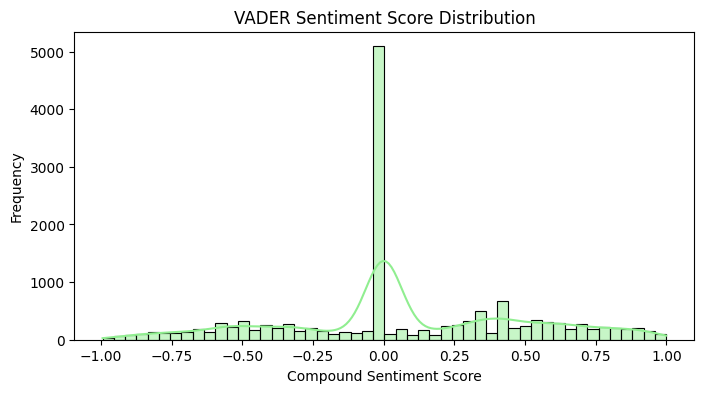

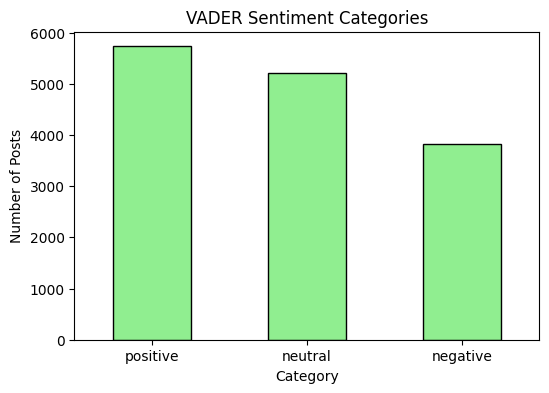

In [6]:
sia = SentimentIntensityAnalyzer()

def vader_sentiment(text):
    score = sia.polarity_scores(text)
    return score['compound']

df['vader_sentiment'] = df['clean_text'].apply(vader_sentiment)
print("Sample Sentiment Scores (VADER):")
print(df[['clean_text', 'vader_sentiment']].head())

def categorize_vader_score(score, pos_threshold=0.05, neg_threshold=-0.05):
    """
    Convert the VADER compound sentiment score into
    'positive', 'negative', or 'neutral' based on threshold bounds.
    """
    if score >= pos_threshold:
        return 'positive'
    elif score <= neg_threshold:
        return 'negative'
    else:
        return 'neutral'

df['vader_category'] = df['vader_sentiment'].apply(categorize_vader_score)

# VADER histogram
plt.figure(figsize=(8,4))
sns.histplot(df['vader_sentiment'], bins=50, kde=True, color='lightgreen', edgecolor='black')
plt.title('VADER Sentiment Score Distribution')
plt.xlabel('Compound Sentiment Score')
plt.ylabel('Frequency')
plt.show()

# VADER category counts
plt.figure(figsize=(6,4))
df['vader_category'].value_counts().plot(kind='bar', color='lightgreen', edgecolor='black')
plt.title("VADER Sentiment Categories")
plt.xlabel("Category")
plt.ylabel("Number of Posts")
plt.xticks(rotation=0)
plt.show()

## Comparative Sentiment Analysis: Lexicon vs VADER 🧮📊

The below code block presents a visual comparison between **Lexicon-based** and **VADER-based** sentiment analysis using two types of plots:

1. **Pie Charts**: These display the proportion of posts categorized as **positive**, **neutral**, or **negative** by each sentiment method, offering a side-by-side comparison of how each approach classifies overall sentiment distribution.

2. **Joint Plot**: This examines the relationship between sentiment scores from both methods. By plotting **Lexicon sentiment scores** on the x-axis and **VADER compound scores** on the y-axis, the joint plot helps visualize any correlation or divergence between the two techniques, with a regression line included to show the trend.


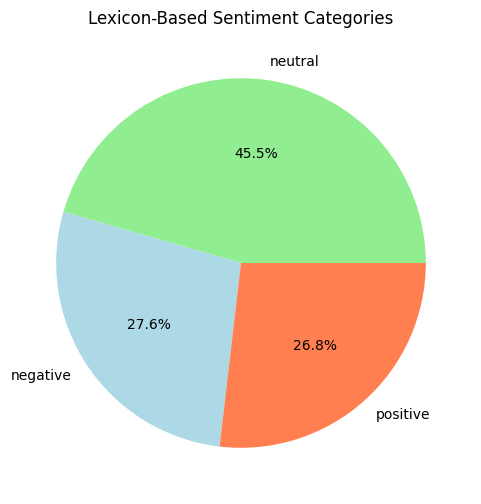

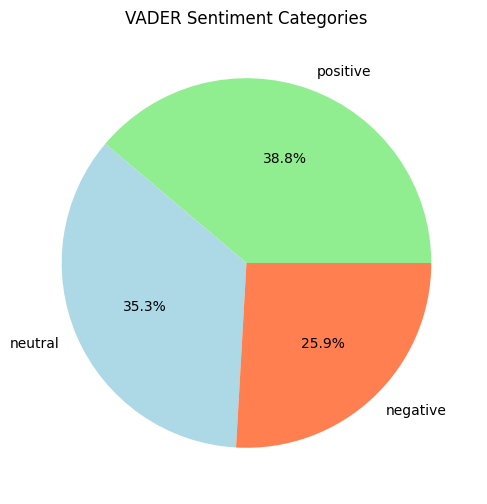

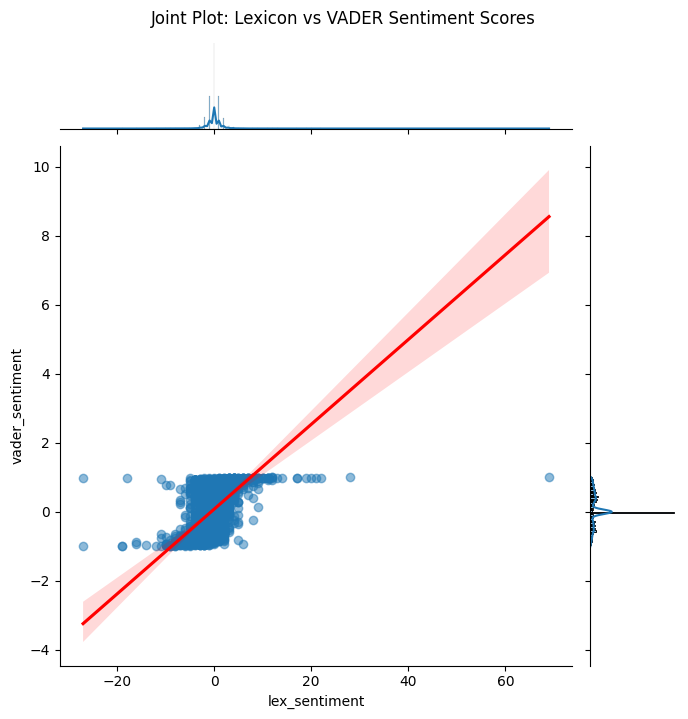

+-------------------------+----------+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| Sentiment               |    Score | Text                                                                                                                                                   |
+=========================+==========+========================================================================================================================================================+
| Most Positive (VADER)   |   0.9991 | [EXPERIMENT - Tracking 2025 Top Ten Cryptocurrencies – Month Three - Down                                                                              |
|                         |          | -22&#37;](https://preview.redd.it/6cqx845h28ue1.png?width=666&format=png&auto=webp&s=89e6bc8b4306412c8471802182573473c5ed1b79)  ***Find the full blog  |
|                         |          | p

In [7]:
# Pie Chart for Lexicon-based Sentiment Categories
plt.figure(figsize=(6,6))
df['lex_category'].value_counts().plot.pie(autopct='%1.1f%%', colors=['lightgreen', 'lightblue', 'coral'])
plt.title('Lexicon-Based Sentiment Categories')
plt.ylabel('')
plt.show()

# Pie Chart for VADER-based Sentiment Categories
plt.figure(figsize=(6,6))
df['vader_category'].value_counts().plot.pie(autopct='%1.1f%%', colors=['lightgreen', 'lightblue', 'coral'])
plt.title('VADER Sentiment Categories')
plt.ylabel('')
plt.show()

# Joint Plot: Lexicon-based vs. VADER Sentiment Scores
sns.jointplot(
    x='lex_sentiment',
    y='vader_sentiment',
    data=df,
    kind='reg',
    height=7,
    scatter_kws={'alpha':0.5},
    line_kws={'color': 'red'}
)
plt.suptitle("Joint Plot: Lexicon vs VADER Sentiment Scores", y=1.02)
plt.show()

def get_extreme_sentiment_rows(df, sentiment_col, title):
    pos_row = df.loc[df[sentiment_col].idxmax()]
    neg_row = df.loc[df[sentiment_col].idxmin()]

    rows = [
        ["Most Positive " + title, pos_row[sentiment_col], pos_row['selftext']],
        ["Most Negative " + title, neg_row[sentiment_col], neg_row['selftext']],
    ]
    return rows

# Combine VADER + Lexicon sentiment results
results = []
results += get_extreme_sentiment_rows(df, 'vader_sentiment', '(VADER)')
results += get_extreme_sentiment_rows(df, 'lex_sentiment', '(Lexicon)')

headers = ["Sentiment", "Score", "Text"]

print(tabulate(results, headers=headers, tablefmt="grid", maxcolwidths=[None, None, 150, 100]))


## Time Based Analysis of Sentiment Scores 📅📊

The following time-series plots show how the **sentiment** expressed in Reddit posts evolves over time:

- The **first plot** tracks sentiment using the **VADER model**, which captures nuanced expressions based on a pre-trained social media lexicon.
- The **second plot** shows sentiment using a **Lexicon-based method**, which relies on counting predefined positive and negative words.

These plots help identify trends, spikes, or shifts in public sentiment around cryptocurrency discussions over the observed period.


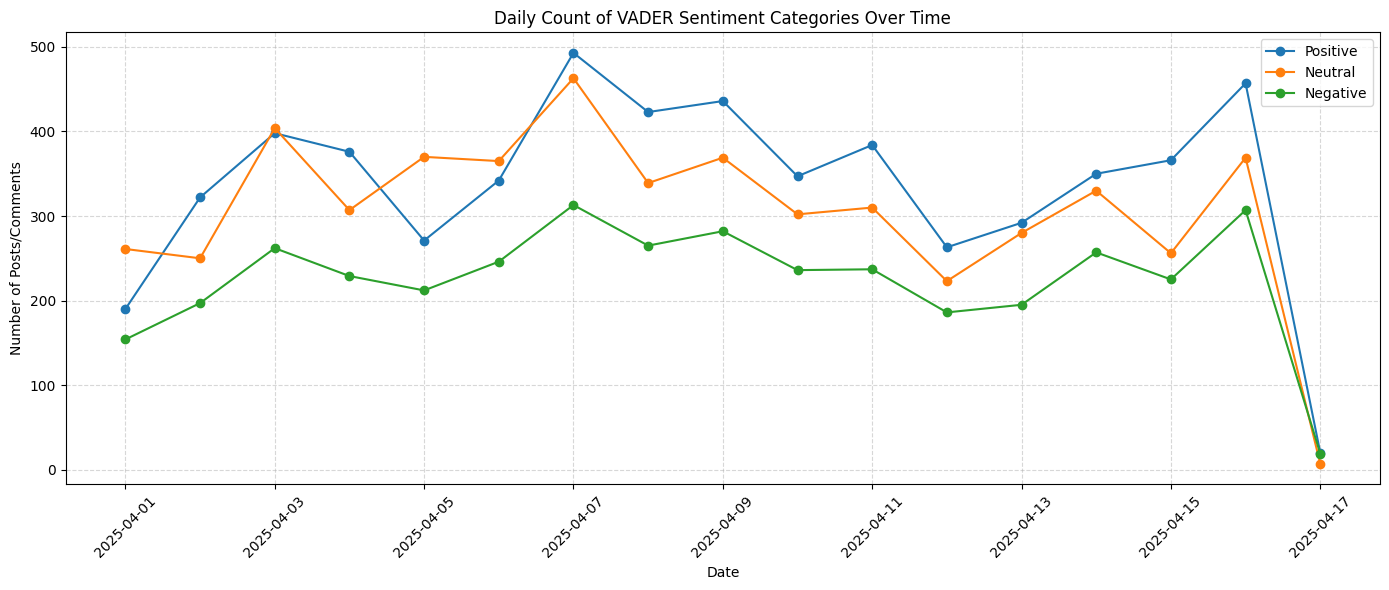

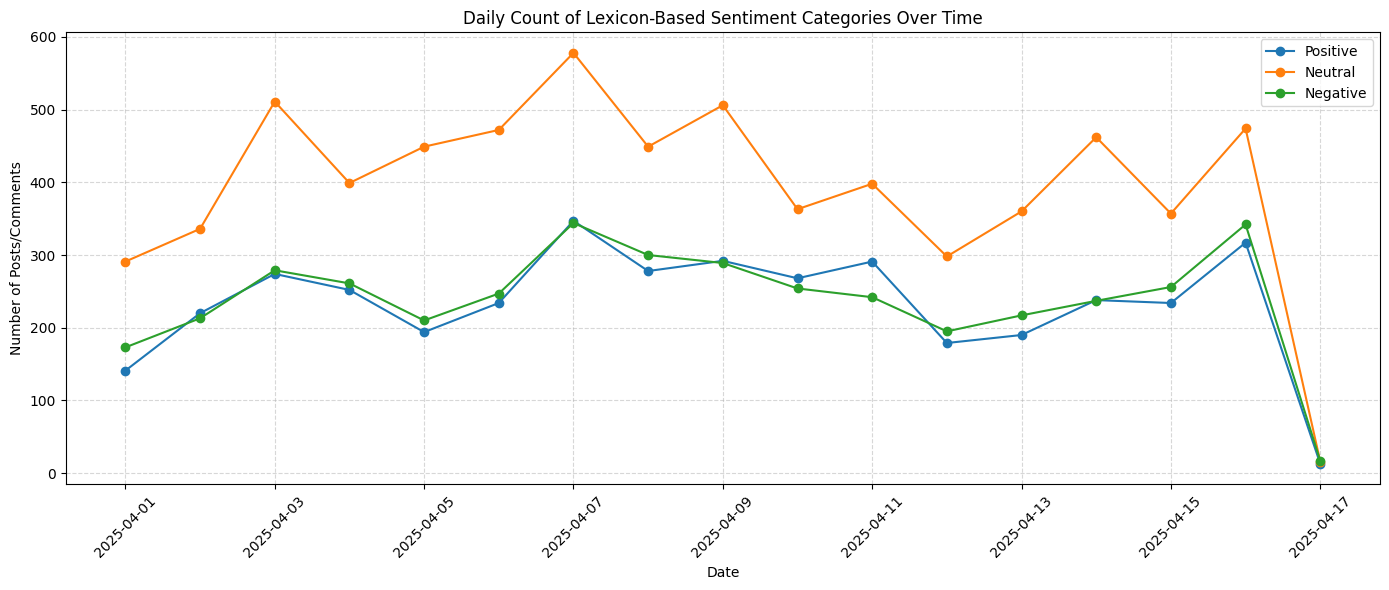

In [8]:
# Ensure date column exists
if 'date' not in df.columns:
    df['date'] = pd.to_datetime(df['created_utc'], unit='s')

def classify_sentiment(score):
    if score > 0.05:
        return 'Positive'
    elif score < -0.05:
        return 'Negative'
    else:
        return 'Neutral'

df['vader_sentiment_label'] = df['vader_sentiment'].apply(classify_sentiment)
vader_counts = df.groupby([df['date'].dt.date, 'vader_sentiment_label']).size().unstack(fill_value=0)
vader_counts.index = pd.to_datetime(vader_counts.index)
vader_counts.sort_index(inplace=True)

df['lex_sentiment_label'] = df['lex_sentiment'].apply(classify_sentiment)
lex_counts = df.groupby([df['date'].dt.date, 'lex_sentiment_label']).size().unstack(fill_value=0)
lex_counts.index = pd.to_datetime(lex_counts.index)
lex_counts.sort_index(inplace=True)

plt.figure(figsize=(14, 6))
for sentiment in ['Positive', 'Neutral', 'Negative']:
    if sentiment in vader_counts.columns:
        plt.plot(vader_counts.index, vader_counts[sentiment], marker='o', label=sentiment)
plt.title("Daily Count of VADER Sentiment Categories Over Time")
plt.xlabel("Date")
plt.ylabel("Number of Posts/Comments")
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 6))
for sentiment in ['Positive', 'Neutral', 'Negative']:
    if sentiment in lex_counts.columns:
        plt.plot(lex_counts.index, lex_counts[sentiment], marker='o', label=sentiment)
plt.title("Daily Count of Lexicon-Based Sentiment Categories Over Time")
plt.xlabel("Date")
plt.ylabel("Number of Posts/Comments")
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

## Topic Modeling with LDA – Visualization using WordCloud & pyLDAvis 🧠📊

The below code block applies **Latent Dirichlet Allocation (LDA)** to uncover hidden topics in Reddit cryptocurrency discussions. It generates:

- A **document-term matrix** using `CountVectorizer`.
- **Topic-word mappings** using LDA with 3 topics.
- **WordCloud visualizations** to display the most influential words per topic.
- An **interactive pyLDAvis panel** (with t-SNE) to explore topic relevance and word distribution across the corpus.

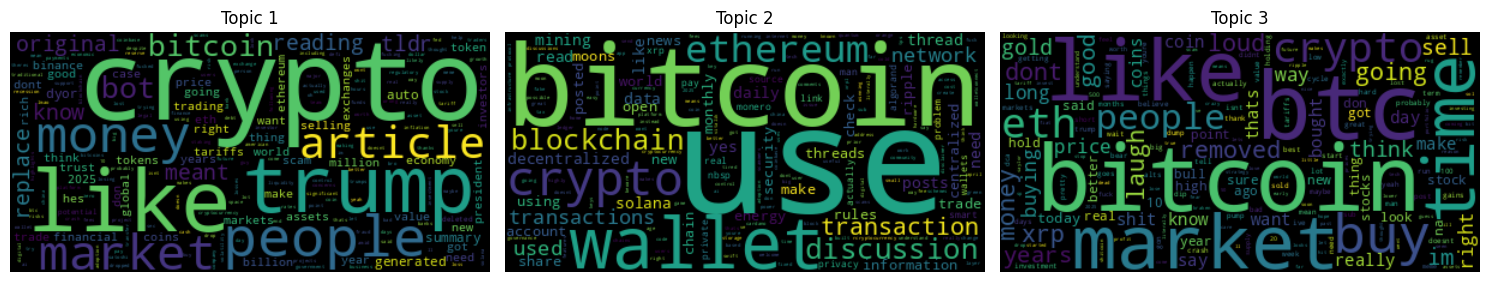

In [9]:
# Create a document-term matrix
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
dtm = vectorizer.fit_transform(df['clean_text'])

# Define the number of topics
num_topics = 3
lda = LatentDirichletAllocation(n_components=num_topics, random_state=69)
lda.fit(dtm)

def display_wordclouds(model, feature_names):
    topic_word_distributions = model.components_ / model.components_.sum(axis=1)[:, np.newaxis]
    plot_cols = 3
    plot_rows = int(np.ceil(model.n_components / plot_cols))

    plt.figure(figsize=(15, 5 * plot_rows))

    for topic_idx, topic_dist in enumerate(topic_word_distributions):
        word_freq = {feature_names[i]: topic_dist[i] for i in range(len(feature_names))}
        wordcloud = WordCloud(background_color='black').generate_from_frequencies(word_freq)

        plt.subplot(plot_rows, plot_cols, topic_idx + 1)
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis("off")
        plt.title(f"Topic {topic_idx + 1}")

    plt.tight_layout()
    plt.show()

display_wordclouds(lda, vectorizer.get_feature_names_out())

pyLDAvis.enable_notebook()
panel = pyLDAvis.lda_model.prepare(lda, dtm, vectorizer, mds='tsne')
pyLDAvis.display(panel)

## Saving Processed Data 💾

The final processed DataFrame, including cleaned text, sentiment scores (Lexicon and VADER), sentiment categories, and any additional derived columns is saved to a CSV file named **`reddit_crypto_analysis.csv`** for further analysis, visualization, or reporting outside of the notebook.

In [10]:
df.to_csv('reddit_crypto_analysis.csv', index=False)
print("Processed data saved to 'reddit_crypto_analysis.csv'")

Processed data saved to 'reddit_crypto_analysis.csv'


## References 📚

- Hutto, C. J., & Gilbert, E. (2014). *VADER: A Parsimonious Rule-based Model for Sentiment Analysis of Social Media Text*. In Proceedings of the International AAAI Conference on Web and Social Media, 8(1). https://ojs.aaai.org/index.php/ICWSM/article/view/14550

- Blei, D. M., Ng, A. Y., & Jordan, M. I. (2003). *Latent Dirichlet Allocation*. Journal of Machine Learning Research, 3, 993–1022. https://www.jmlr.org/papers/volume3/blei03a/blei03a.pdf

- scikit-learn: Machine Learning in Python. Pedregosa et al., JMLR 12, pp. 2825-2830, 2011. https://scikit-learn.org/

- Bird, S., Klein, E., & Loper, E. (2009). *Natural Language Processing with Python: Analyzing Text with the Natural Language Toolkit*. O’Reilly Media. (Used for stopwords, tokenization, and sentiment analysis with VADER)

- pyLDAvis: Interactive Topic Modeling Visualization. https://github.com/bmabey/pyLDAvis

- PRAW: The Python Reddit API Wrapper. https://praw.readthedocs.io/

- Matplotlib: Visualization with Python. https://matplotlib.org/

- Seaborn: Statistical Data Visualization. https://seaborn.pydata.org/

- WordCloud for Python. https://github.com/amueller/word_cloud

- Reddit data sourced from the [r/CryptoCurrency subreddit](https://www.reddit.com/r/CryptoCurrency/)

- Sentiment lexicons from:
  - Hu, M., & Liu, B. (2004). *Mining and Summarizing Customer Reviews*. Proceedings of the ACM SIGKDD International Conference on Knowledge Discovery & Data Mining. https://www.cs.uic.edu/~liub/FBS/sentiment-analysis.html

